Class Final Project: NYC Taxi duration - visuals

In [2]:
# imports

import numpy as np
import pandas as pd

from sklearn.metrics import accuracy_score
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn import metrics
from matplotlib import pyplot as plt 

/Users/thp/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Import the training dataset and start preprocessing the data

In [64]:
# import the dataset and check
taxi = pd.read_csv('/Users/thp/Documents/CSULA/5661 Data Science/Project/train.csv')
print(taxi.shape)
taxi.head()

(1458644, 11)


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


### in this data set, we found out that some columns are not necessary for the prediction. 
### For example, "id" and "vendor_id" and "store_and_fwd_flag" column, so we first drop those.

In [65]:
taxi_new = taxi.drop(['id','vendor_id','store_and_fwd_flag'],axis=1)
taxi_new.head()

,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
0,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,455
1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,663
2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,2124
3,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,429
4,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,435


#### In further observation, we found that Pick-up time - Drop-off time = trip duration, 
#### so if we just need to find out what time the taxi pick people up, we can omit the drop-off column.
### To easily capture the hour results, use the following code: 

In [66]:
taxi_new_h = pd.to_datetime(taxi_new["pickup_datetime"]) 
taxi_new['hour'] = taxi_new_h.map(lambda x: x.hour)
taxi_new.head()

,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,hour
0,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,455,17
1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,663,0
2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,2124,11
3,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,429,19
4,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,435,13


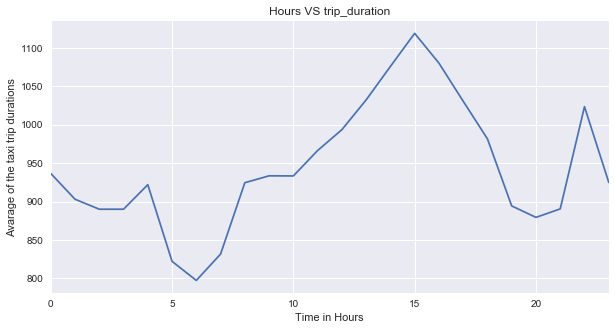

In [195]:
figure,axes = plt.subplots(figsize = (10, 5))
hours = taxi_new.groupby(["hour"]).agg(('mean'))["trip_duration"]  
hours.plot(kind="line", ax=axes) 
plt.title('Hours VS trip_duration')
axes.set_xlabel('Time in Hours')
axes.set_ylabel('Avarage of the taxi trip durations')
plt.show()

#### we can see that we have a column 'hour' that captures the hour of the day when the taxi picks up the customer. 
#### we believe that this timing of the ride is very important. 
### To avoid numeric relationship, we categorize the hour of a day by 5 differnt time zones:

In [29]:
def cateHours(x):
    if 0 <= x <= 5:
        return "EM"    # Early Morning, mono decrease
    elif 6 <= x <= 15:
        return "MP"    # Morning Peak, mono increase
    elif 16 <= x <= 19:
        return "AF"    # Afternoon to night time, mono decrease
    elif 20 <= x <= 22:
        return "AP"   # Night peak, mono increase
    elif 23 <= x <= 24:
        return "LN"   # Late Night, mono decrase 

### Then we apply this function to the dataset to change the 'hour' column to discrete values: 

In [67]:
taxi_new['hour'] = taxi_new['hour'].apply(cateHours)
taxi_new.head()

,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,hour
0,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,455,AF
1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,663,EM
2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,2124,MP
3,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,429,AF
4,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,435,MP


In [68]:
# One hot encoding 

taxi_new_onehotHour = pd.get_dummies(taxi_new['hour'])
taxi_new_onehotHour.head()

,AF,AP,EM,LN,MP
0,1,0,0,0,0
1,0,0,1,0,0
2,0,0,0,0,1
3,1,0,0,0,0
4,0,0,0,0,1


In [199]:
time = taxi_new.set_index('trip_duration')

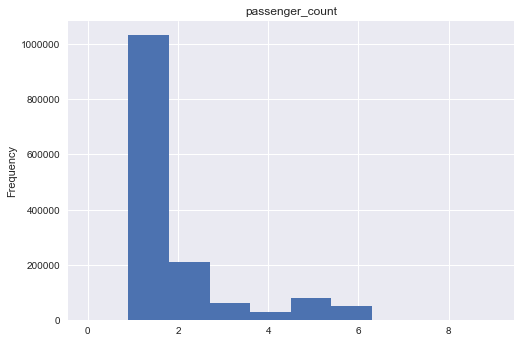

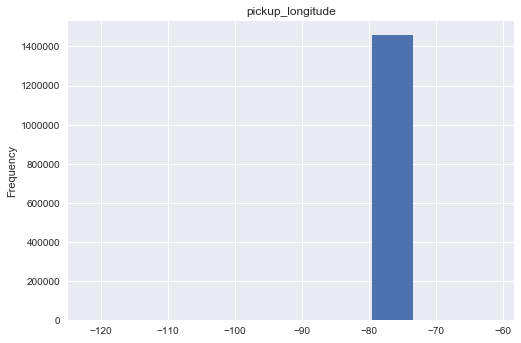

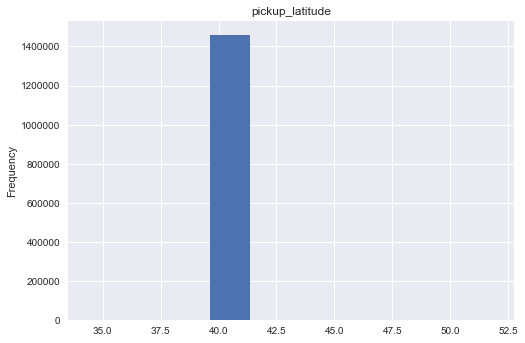

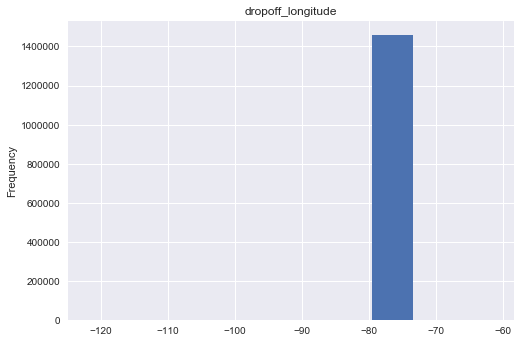

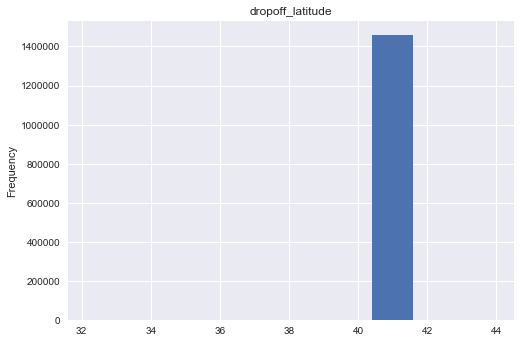

In [200]:
feature_cols = ['passenger_count','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']

for f in feature_cols:
    plt.figure()
    plt.title(f)
    time[f].plot(kind='hist')
    plt.show()
    
    


### Then we use OneHot Encoding for column 'hour'

In [75]:
# put this into the dataset

taxi_new = pd.concat([taxi_new,taxi_new_onehotHour], axis=1)
taxi_new.head()


,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,hour,AF,AP,EM,LN,MP
0,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,455,AF,1,0,0,0,0
1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,663,EM,0,0,1,0,0
2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,2124,MP,0,0,0,0,1
3,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,429,AF,1,0,0,0,0
4,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,435,MP,0,0,0,0,1


In [76]:
taxi_new.head()

,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,hour,AF,AP,EM,LN,MP
0,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,455,AF,1,0,0,0,0
1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,663,EM,0,0,1,0,0
2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,2124,MP,0,0,0,0,1
3,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,429,AF,1,0,0,0,0
4,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,435,MP,0,0,0,0,1


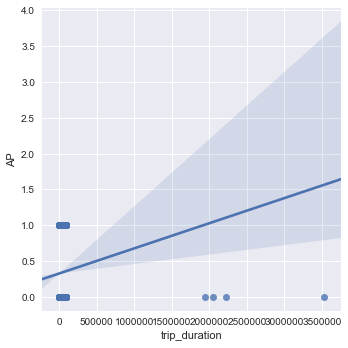

In [202]:
import seaborn as sns
sns.lmplot(x='trip_duration', y='AP', data=taxi_new)
plt.show()

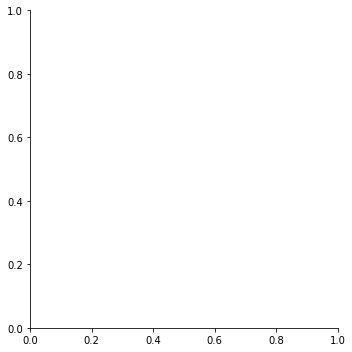

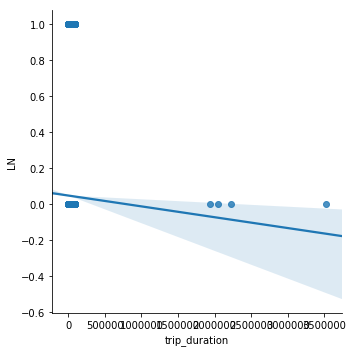

In [77]:
import seaborn as sns
sns.lmplot(x='trip_duration', y='LN', data= taxi_new)
plt.show()

### After getting the pick-up time zone, we can drop the pickup_datetime and dropoff_datetime
### but before we do that, let make the Label first. 

In [10]:
label = taxi_new['trip_duration']
label.shape

(1458644,)

### Direct Distance from Andrew

In [33]:
from math import cos, asin, sqrt, sin, atan2, radians
def getDistanceFromLatLon(lat1,lon1,lat2,lon2):
    R = 3959 # Radius of the earth in miles
    dLat = radians(lat2-lat1)  #deg2rad below
    dLon = radians(lon2-lon1) 
    a = sin(dLat/2) * sin(dLat/2) + cos(radians(lat1)) * cos(radians(lat2)) * sin(dLon/2) * sin(dLon/2)
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    d = R * c; #Distance in km
    #print(d)
    return d

def f(x):
    return getDistanceFromLatLon(x[0], x[1], x[2], x[3])


In [79]:
taxi_new['distance'] = taxi_new[['pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude']].apply(f, axis =1)
taxi_new['distance'].head()

0    0.931195
1    1.121959
2    3.967761
3    0.923103
4    0.738600
Name: distance, dtype: float64

In [80]:
taxi_new.head()

,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,hour,AF,AP,EM,LN,MP,distance
0,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,455,AF,1,0,0,0,0,0.931195
1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,663,EM,0,0,1,0,0,1.121959
2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,2124,MP,0,0,0,0,1,3.967761
3,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,429,AF,1,0,0,0,0,0.923103
4,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,435,MP,0,0,0,0,1,0.738600


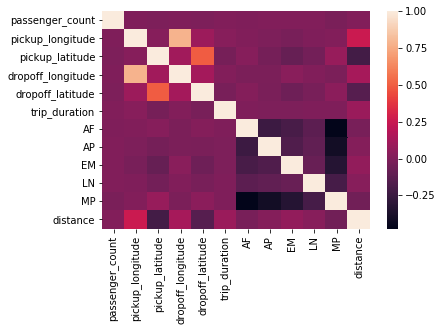

In [36]:
# Calculate correlations
corr = taxi_new.corr()
 
# Heatmap
sns.heatmap(corr)
plt.show()

In [ ]:
.agg(('mean'))

In [ ]:
figure,axes = plt.subplots(figsize = (10, 5))
distance = taxi_new.groupby(["distance"])["trip_duration"]  
distance.plot(kind="line", ax=axes) 
plt.title('Distance VS trip_duration')
axes.set_xlabel('Distance')
axes.set_ylabel('Trip durations')
plt.show()

### then drop all unnecessary columns, and make the feature matrix

In [37]:
taxi_new = taxi_new.drop(['pickup_datetime','dropoff_datetime','hour','trip_duration'],axis=1)
taxi_new.head()

,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,AF,AP,EM,LN,MP,distance
0,1,-73.982155,40.767937,-73.964630,40.765602,1,0,0,0,0,0.931195
1,1,-73.980415,40.738564,-73.999481,40.731152,0,0,1,0,0,1.121959
2,1,-73.979027,40.763939,-74.005333,40.710087,0,0,0,0,1,3.967761
3,1,-74.010040,40.719971,-74.012268,40.706718,1,0,0,0,0,0.923103
4,1,-73.973053,40.793209,-73.972923,40.782520,0,0,0,0,1,0.738600


In [23]:
taxi_new = taxi_beforeScalled

#### Scaling may help to normalize the data: 

In [59]:
from sklearn import preprocessing

taxi_beforeScalled = taxi_new   ## back up before scalling

taxi_scaled = preprocessing.scale(taxi_new)
taxi_new = pd.DataFrame(taxi_scaled)
taxi_new.head()


,0,1,2,3,4,5,6,7,8,9,10
0,-0.505637,-0.122261,0.517494,0.124369,0.384575,1.879925,-0.453426,-0.364997,-0.224157,-0.892739,-0.452072
1,-0.505637,-0.097727,-0.375819,-0.368970,-0.575303,-0.531936,-0.453426,2.739745,-0.224157,-0.892739,-0.380622
2,-0.505637,-0.078143,0.395910,-0.451805,-1.162220,-0.531936,-0.453426,-0.364997,-0.224157,1.120148,0.685258
3,-0.505637,-0.515558,-0.941274,-0.549976,-1.256071,1.879925,-0.453426,-0.364997,-0.224157,-0.892739,-0.455103
4,-0.505637,0.006112,1.286091,0.006974,0.855957,-0.531936,-0.453426,-0.364997,-0.224157,1.120148,-0.524207


# Algorithm selection:
##### We select Linear Regression, Lasso, ElasticNet, and Ridge to perform regression, and compare them together 

In [38]:
# Frist define the RMSE method. 

def RMSE(y_test,y_predict):
    # Calculating "Mean Square Error" (MSE):
    mse = metrics.mean_squared_error(y_test, y_predict)
    # Using numpy sqrt function to take the square root and calculate "Root Mean Square Error" (RMSE)
    rmse = np.sqrt(mse)
    return(rmse)

In [61]:
# Define a method to run all 4 regression at the same time:

def Regressions(feature,label):
    
    # split the dataset into training and testing sets by 80-20 ratio
    X_train, X_test, y_train, y_test = train_test_split(feature, label, test_size=0.2, random_state=3)
    
    
    #linear
    from sklearn.linear_model import LinearRegression
    myLinearReg = LinearRegression()
    myLinearReg.fit(X_train,y_train)
    y_predict = myLinearReg.predict(X_test)    
    print('Linear ',RMSE(y_test,y_predict))
    
    y_predict = myLinearReg.predict(X_train)
    print('Linear Train',RMSE(y_train,y_predict),'\n')    ## Output the RMSE on the Training set. 
    
    #Ridge
    from sklearn.linear_model import Ridge
    myRidge = Ridge()
    myRidge.fit(X_train,y_train)
    y_predict = myRidge.predict(X_test)
    print('Ridge ', RMSE(y_test,y_predict))

    y_predict = myRidge.predict(X_train)
    print('Ridge Train', RMSE(y_train,y_predict),'\n')    ## Output the RMSE on the Training set. 
    
    #ElasticNet
    from sklearn.linear_model import ElasticNet
    myENet = ElasticNet()
    myENet.fit(X_train,y_train)
    y_predict = myENet.predict(X_test)
    print('ElasticNet ', RMSE(y_test,y_predict))
    
    y_predict = myENet.predict(X_train)
    print('ElasticNet Train', RMSE(y_train,y_predict),'\n')
    
    #Lasso
    from sklearn.linear_model import Lasso
    myLasso = Lasso()
    myLasso.fit(X_train,y_train)
    y_predict = myLasso.predict(X_test)
    print('Lasso ', RMSE(y_test,y_predict))
    
    y_predict = myLasso.predict(X_train)
    print('Lasso Train', RMSE(y_train,y_predict),'\n')
    
    
    # 10-fold Cross validation:
    rmse_list = cross_val_score(myLasso, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
    #print(rmse_list)

    # Notice that "cross_val_score" by default provides "negative" values for "mse" to clarify that mse is error.
    # in order to calculate root mean square error (rmse), we have to make them positive!
    mse_list_positive = -rmse_list

    # using numpy sqrt function to calculate rmse:
    rmse_list = np.sqrt(mse_list_positive)
    #print(rmse_list)

    print('cross-validation',rmse_list.mean())


### Also, in order to reduce work load and compare result, we create a method to split the dataset 

In [40]:
def shrinkDataSet (train,label,times, splitSize):   #times= how many times to split the original dataset
    X_train = train
    y_train = label
    for i in range (0,times):
        X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=splitSize, random_state=3)        
    return X_train, y_train

#### Split the dataset to make it smaller: 

In [41]:
# use spliting 5 times as example.

taxi_reduced, label_reduced = shrinkDataSet (taxi_new,label,5,0.5)    # split 5 times, into half

print('original: ',taxi_new.shape)
print('After: ',taxi_reduced.shape)


original:  (1458644, 11)
After:  (45582, 11)


In [62]:
def Run_compare(k):        # K = how many times to split
    
    taxi_reduced, label_reduced = shrinkDataSet (taxi_new,label, k ,0.5)    # split k times, into half
    print('Original shape: ',taxi_new.shape)
    print('After shape: ',taxi_reduced.shape,'\n')
    
    Regressions(taxi_reduced,label_reduced)

Original shape:  (1458644, 10)
After shape:  (5697, 10) 

Linear  1780.31324731
Linear Train 2877.55620639 

Ridge  1780.14500926
Ridge Train 2877.51993951 

ElasticNet  1807.14705691
ElasticNet Train 2882.81447578 

Lasso  1780.44201904
Lasso Train 2877.52232499 

cross-validation 2126.98030196


# start predicting: 

### First, Define a method for easy comparing:

In [63]:
# with k=8

k=8

Run_compare(k)

Original shape:  (1458644, 11)
After shape:  (5697, 11) 

Linear  1677.38367183
Linear Train 2850.67764143 

Ridge  1677.4026249
Ridge Train 2850.6776485 

ElasticNet  1716.15264197
ElasticNet Train 2856.9494962 

Lasso  1677.07258237
Lasso Train 2850.68223431 

cross-validation 2021.76111409


In [44]:
# with k=5

k=5

Run_compare(k)

Original shape:  (1458644, 11)
After shape:  (45582, 11) 

Linear  2360.00212068
Linear Train 3139.21822558 

Ridge  2359.9389808
Ridge Train 3139.21934679 

ElasticNet  2360.50990752
ElasticNet Train 3141.12840396 

Lasso  2359.43538113
Lasso Train 3139.65687642 

cross-validation 3120.46497092


In [55]:
# with k=3

k=3

Run_compare(k)

Original shape:  (1458644, 11)
After shape:  (182330, 11) 

Linear  3122.76943374
Linear Train 2993.6234682 

Ridge  3122.77069386
Ridge Train 2993.62347391 

ElasticNet  3123.88277372
ElasticNet Train 2994.63109028 

Lasso  3123.09736192
Lasso Train 2993.82103544 

cross-validation 2980.58463961


NameError: name 'final_submit' is not defined

In [46]:
# with k=1

k=1

Run_compare(k)

Original shape:  (1458644, 11)
After shape:  (729322, 11) 

Linear  3130.13732036
Linear Train 6827.78006402 

Ridge  3130.13736018
Ridge Train 6827.7800642 

ElasticNet  3130.92467467
ElasticNet Train 6828.24569576 

Lasso  3130.33679291
Lasso Train 6827.85985898 

cross-validation 5276.14189853


In [49]:
# with k=0 , not spliting at all

k=0

Run_compare(k)

Original shape:  (1458644, 11)
After shape:  (1458644, 11) 

Linear  4774.16988657
Linear Train 5317.03045721 

Ridge  4774.16895939
Ridge Train 5317.03045751 

ElasticNet  4772.98346594
ElasticNet Train 5317.98241472 

Lasso  4773.79623661
Lasso Train 5317.15883643 

cross-validation 4455.35744246


NameError: name 'y_predict' is not defined

## From article, if we compare the RMSE from the Predicted RMSE and the Training RMSE, and if they are similar, it's good. 
## RMSE doesn't have a specific threadhold to say "below xxx is good". 
## Therefore, we can see that at k=8, the RMSE of predicted and training are the closest. 

## In this case, I can say that when we split the dataset into 3 times, providing about 180k rows of data, the model is trained to the best fit. 

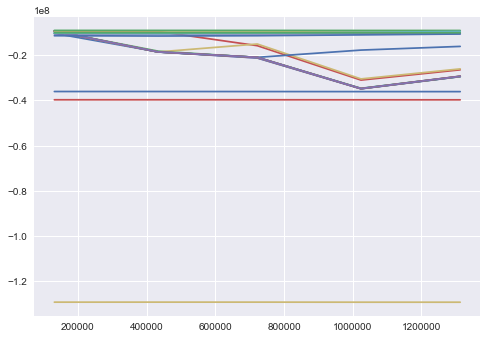

In [220]:
#Plot learning curve
from sklearn.model_selection import learning_curve
train_sizes_abs, train_scores, test_scores = learning_curve(my_linreg ,X, y, n_jobs=-1,cv=10, verbose=0, scoring='neg_mean_squared_error',train_sizes=np.array([ 0.1, 0.33, 0.55, 0.78, 1. ]))
plt.plot(train_sizes_abs, train_scores)
plt.plot(train_sizes_abs, test_scores)
plt.show()

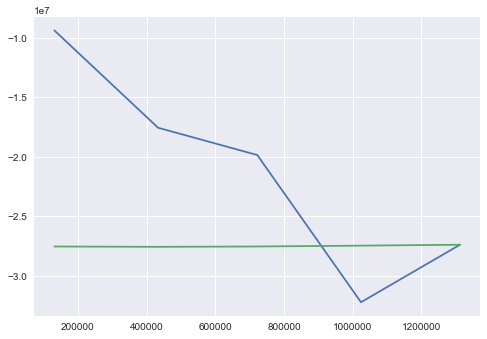

In [221]:
#Mean learning curves for different cross validation folds
train_score_mean = np.mean(train_scores,axis=1)
test_score_mean = np.mean(test_scores,axis=1)
plt.plot(train_sizes_abs,train_score_mean)
plt.plot(train_sizes_abs, test_score_mean)
plt.show()